# Modeling of replication state


## Initial "clairvoyant" model based on

*`Giroire, Frederic, Julian Monteiro, and Stéphane Pérennes. ‘Peer-to-Peer Storage Systems: A Practical Guideline to Be Lazy’. In 2010 IEEE Global Telecommunications Conference GLOBECOM 2010, 1–6, 2010. https://doi.org/10/c47cmb.`*


Code based on
- https://github.com/TommasoBelluzzo/PyDTMC
- https://ipython-books.github.io/131-simulating-a-discrete-time-markov-chain/

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
!pip install PyDTMC --quiet
import pydtmc
plt.rcParams['figure.figsize'] = [15, 8]

Our first model, based on [Giroire2010], assumes perfect visibility of redundancy state of individual erasure coded blocks, and the consequent immediate triggering of the reconstruction process. It models $(n,k)$ MDS erasure coding, with any $k$ of $n$ chunks enough to successfully reconstruct all $n$ erasure coded chunks.

It models $r$, the current level of redundancy, which is the current amount of chunks available over $k$

It assumes an $r_0$ threashold. If redundancy reaches that level, reconstruction starts immediately.

It is not modelling behvious below $k$ available chunks. As soon as the number of chunks go below $k$, the block is assumed to be lost. (For reasons of modeling, it is assumed that a lost block is replaced by a new fully redundant block.)





In [ ]:
k = 16 # (K) initial fragments of a block
n = 32 # coded fragments
# r = n-k # redundancy fragments
r0 = 8 # reconstruction threshold


### The DTMC model

Lets use a discrete time model with time step τ.

The basis of state transition probabilities is disk (node) failure rates and reconstruction time. There are various statistics about disk failures, see e.g. https://www.usenix.org/conference/fast-07/disk-failures-real-world-what-does-mttf-1000000-hours-mean-you

As a first approximation, one could start from MTTF numbers and try to factor in other reasons of permanent node failure. 

With a given MTTF and assuming i.i.d. disk failures, the probability for a disk to fail during a timestep is α = 1/MTTF. Reconstruction might also be going on. If reconstruction is on-going, and reconstruction of a block takes MTTR time steps, the probability of a block beeing reconstructed in a time step can be modeled as γ = 1/MTTR.


In [ ]:
τ = 1 # time step [hours].
MTTF = 1e+4 # mean time to failure [hours]. Although disks are specified to MTTF in the range of 1e+6, these numbers are irrealistic for node failures.
MTTR = 12 # mean time to reapair [hours]

The model has r+2 states: 
- r+1 states of enough redundancy, from 0 to r chunks of redundancy,
- and one special state where redundancy is not enough, and the block is lost.

The original figure from the paper is shown below

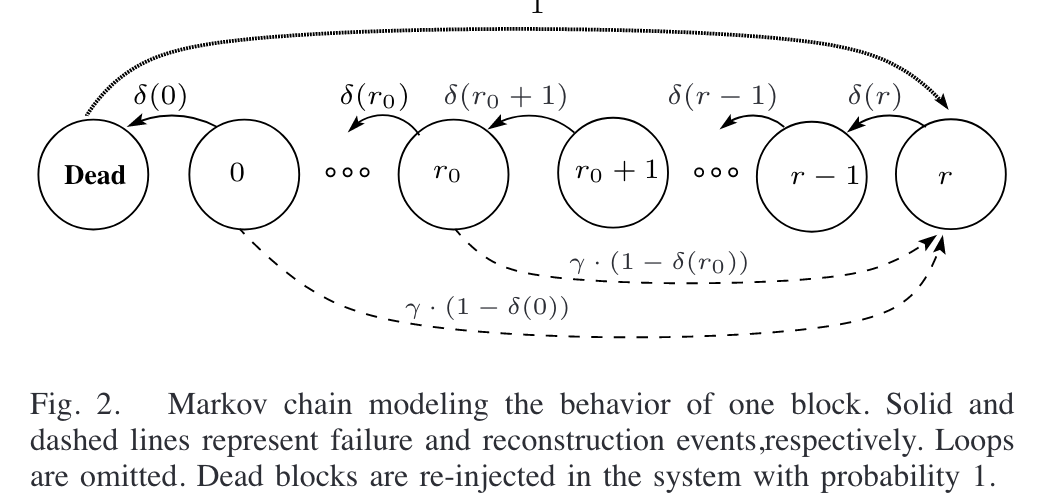

In [ ]:
def dtmc_clearvoyant(k, n, r0, tau, mttf, mttr):

  r = n-k
  alpha = tau/mttf # probability of disk failure in a timestep
  gamma = min(1, tau/mttr) # probabilty of disk reconstructed in a timestep

  # State transition matrix:
  # index is the amount of redundancy, shifted by 1 
  # - 0: less that k good chunks, i.e. dead block
  # - i: k+(i-1) chunks are good, r-(i-1) chunks erased 
  p = np.zeros((r+2,r+2))

  def delta(i):
    # chunk loss probability in a timestep given i redundancy
    return (k+i) * alpha

  for i in range(0,r+1):
    p[i+1,i] = delta(i)
  for i in range(0, r0+1):
    p[i+1,r+1] = gamma * (1 - delta(i))
  p[0,r+1] = 1
  for i in range(0, r+2):
    t = 0
    for j in range(0, r+2):
      t += p[i,j]
    p[i,i] = 1 - t

  mc = pydtmc.MarkovChain(p)
  return mc

In [ ]:
mc = dtmc_clearvoyant(k, n, r0, τ, MTTF, MTTR)

In [ ]:
#pydtmc.plot_graph(mc)

Let's derive the expected distribution of replication state (measured as available redundancy) for individual blocks. 

In [ ]:
statdist = mc.stationary_distributions[0]

In [ ]:
def plot_dist(statdist):
  x = np.arange(len(statdist))
  plt.rcParams['figure.figsize'] = [15, 8]
  plt.subplot(211)
  plt.xticks(x-1)
  plt.xlabel("redundancy (extra chunks)")
  plt.bar(x-1, statdist)
  plt.subplot(212)
  plt.yscale('log')
  plt.xticks(x-1)
  plt.xlabel("redundancy (extra chunks)")
  plt.bar(x-1, statdist)

In [ ]:
plot_dist(statdist)

### Loss Rate

Loss rate is derived from the state representing dead blocks with r below 0.
$$LossRate = P (dead)/τ$$ 

In [ ]:
def lossrate(mc, tau): 
  statdist = mc.stationary_distributions[0]
  LossRateBlock = statdist[0] / τ 
  return LossRateBlock

print("block loss rate:", lossrate(mc, τ), "/hour")

System level loss rate is derived from the state representing dead blocks with r below 0.
$$LossRate = B · P (dead)/τ$$ 
Where $B$ is the total number of blocks in the system, and $τ$ is the time unit (used to derive transition probabilities).

In [ ]:
N = 500 #number of peers
D = 20e+12 # total amount of data in the system [bytes]
l_f = 320e+3 # chunk size [bytes]
l_b = k * l_f # erasure block size

In [ ]:
B = D/l_b #number of blocks in the system
print("number of blocks:", B)

In [ ]:
LossRateSystem = B * statdist[0] / τ 
print("block loss rate at system level:", LossRateSystem, "/hour")

### Repair Bandwidth

Lazy repair allows for the optimization of repair bandwith by starting repair only when several chunks are missing.

The amount of data needed to reconstruct a missing block is k chunks, independent of the number of missing chunks (which is $r-i$ with replication state $i$ . If repair is done independently for each missing chunk, the traffic generated is $(r-i) * k$ chunks, meaning that is does not really matter when we start repair.

If, instead, there is a repair node, it can generate all $r-i$ missing chunks and distribute these, at a cost of $k + r-i-1$ chunk transfers (assuming one of the chunks is stored by the repair node).

In [ ]:
def repair_bw(mc, k, n, tau):
  r = n-k
  statdist = mc.stationary_distributions[0]
  bw = 0
  for i in range(1, r+1):
    bw += statdist[i] * mc.p[i,r+1] * (k + r - i - 1) / tau

  return bw/k


In [ ]:
k=16
n=32
tau=1
mttf=1e4
mttr=12
r0=np.arange(0,n-k)

def plot_clearvoyant(k, n, r0, tau, mttf, mttr):
  clearvoyant = np.vectorize(dtmc_clearvoyant)(k, n, r0, tau, mttf, mttr)
  bw = np.vectorize(repair_bw)(clearvoyant, k, n, tau)
  loss = np.vectorize(lossrate)(clearvoyant, tau)

  plt.plot(loss, bw, '-o', label=f'RS({n},{k})')
  plt.ylabel("repair bandwidth [chunks/hour]")
  plt.xlabel("loss rate [per hour]")
  plt.xscale('log')
  for i, txt in enumerate(r0):
    plt.annotate(txt, (loss[i], bw[i]))

def plot_clearvoyant_r0(k, n, tau, mttf, mttr):
  r0=np.arange(0,n-k)
  plot_clearvoyant(k, n, r0, tau, mttf, mttr)


tau=1
mttf=1e4
mttr=240
plot_clearvoyant_r0(10, 15, tau, mttf, mttr)
plot_clearvoyant_r0(16, 32, tau, mttf, mttr)
plot_clearvoyant_r0(50, 100, tau, mttf, mttr)
plt.legend()
plt.show()


# Modeling of verification

Until now, we have considered a system where the state of each erasure coded block is perfectly visible, and thus reconstruction is based on perfect information. Here we model what happens if information is only partial.

We can differentiate between the following two repair approaches:
- performs a single test and start repair as soon as it fails
- estimate $r$ based on a test and start repair based on this estimate

First, lets assume a repair process that is triggered by a simple verification process with the following parameters:
- $fail(r)$ is the negative outcome of the verification (test failed) as a function of the actual state of redundancy

In [ ]:
def fail(i): # assuming the simplest test of checking one block
  return 1 - (k+i) / (k+r)


Lets see how these modify our transition matrix. If a block is not verified, it cannot start repair. If instead a block is being verified, there is $fail(r)$ chance it starts repair, while $1 - fail(r)$ nothing will happen.

In [ ]:
def dtmc_simplequery(k, n, tau, mttf, mttr):

  r=n-k
  alpha = tau/mttf # probability of disk failure in a timestep
  gamma = min(1, tau/mttr) # probabilty of disk reconstructed in a timestep

  def fail(i): # assuming the simplest test of checking one block
    return 1 - (k+i) / (k+r)

  def delta(i):
    # chunk loss probability in a timestep given i redundancy
    return (k+i) * alpha

  p = np.zeros((r+2,r+2))
  for i in range(0,r+1):
    p[i+1,i] = delta(i)
  for i in range(0, r):
    p[i+1,r+1] = gamma * fail(i+1)
  p[0,r+1] = 1
  for i in range(0, r+2):
    t = 0
    for j in range(0, r+2):
      t += p[i,j]
    p[i,i] = 1 - t

  mc = pydtmc.MarkovChain(p)
  return mc

In [ ]:
mc = dtmc_simplequery(k, n, τ, MTTF, MTTR)

In [ ]:
statdist = mc.stationary_distributions[0]
plot_dist(statdist)

In [ ]:
LossRate = B * statdist[0] / τ 
print("block loss rate:", LossRate, "/hour")

In [ ]:
from scipy.stats import hypergeom

def dtmc_multiquery(k, n, l, maxfail, tau, mttf, mttr):
  # k: initial fragments of a block
  # n: coded fragments
  # l: query length
  # maxfail: max failures allowed (-1: test always fails, 0: test passes only if all are good, 1: allows one to fail ... l: always pass)
  # tau: time step [hours].
  # mttf: mean time to failure [hours].

  alpha = tau/mttf # probability of disk failure in a timestep
  gamma = min(1, tau/mttr) # probabilty of disk reconstructed in a timestep, lower bound to 1 timestep
  r = n-k # redundancy fragments
  p_v = 1 

  def fail(i): # prob. test failed with i redundancy of r remaining
    #return 1 - hypergeom(n, k+i, l).sf(r-maxfail) #n chunks, of which k+i are good (r-i are bad), l are tested, fail if at least f fail
    return hypergeom(n, r-i, l).sf(maxfail) #n chunks, of which k+i are good (r-i are bad), l are tested, fail if at least maxfail fail

  def delta(i):
    return (k+i) * alpha

  p = np.zeros((r+2,r+2))
  for i in range(0,r+1):
    p[i+1,i] = delta(i)
  for i in range(0, r):
    p[i+1,r+1] = gamma * p_v * fail(i+1)
  p[0,r+1] = 1
  for i in range(0, r+2):
    t = 0
    for j in range(0, r+2):
      t += p[i,j]
    p[i,i] = 1 - t

  mc = pydtmc.MarkovChain(p)
  return mc

τ = 1 # time step [hours].
MTTF = 1e+4 # mean time to failure [hours]. Although disks are specified to MTTF in the range of 1e+6, these numbers are irrealistic for node failures.
alpha = 1/MTTF # probability of disk failure in a timestep
MTTR = 50 # probabilty of disk reconstructed in a timestep
K = 16 # (K) initial fragments of a block
N = 32 # coded fragments
L = 6 #query length
MAXFAIL = 2 #max failures allowed (-1: test always fails, 0: test passes only if all are good, 1: allows one to fail ... l: always pass)

mc = dtmc_multiquery(K, N, L, MAXFAIL, L, MTTF, MTTR)
statdist = mc.stationary_distributions[0]

#plt.yscale('log')
plot_dist(statdist)
LossRate = B * statdist[0] / τ 
print("block loss rate:", LossRate, "/hour")

In [ ]:
def plot_multiquery(k, n, l, maxfail, tau, mttf, mttr):
  mcs = np.vectorize(dtmc_multiquery)(k, n, l, maxfail, tau, mttf, mttr)
  bw = np.vectorize(repair_bw)(mcs, k, n, tau)
  loss = np.vectorize(lossrate)(mcs, tau)

  plt.plot(loss, bw, '-o', label=f'RS({n},{k}) - mq({maxfail}/{l})')
  plt.ylabel("repair bandwidth [chunks/hour]")
  plt.xlabel("loss rate [per hour]")
  plt.xscale('log')
  plt.yscale('log')
  for i, txt in enumerate(maxfail):
    plt.annotate(txt, (loss[i], bw[i]))

def plot_multiquery_maxfail(k, n, l, tau, mttf, mttr):
  maxfail=np.arange(0, l)
  plot_multiquery(k, n, l, maxfail, tau, mttf, mttr)


In [ ]:
tau=1
mttf=1e4
mttr=24
plot_multiquery_maxfail(16, 32, 8, 8*tau, mttf, mttr)
plot_multiquery_maxfail(16, 32, 4, 4*tau, mttf, mttr)
plot_multiquery_maxfail(16, 32, 1, 1*tau, mttf, mttr)
plot_multiquery_maxfail(50, 100, 8, 8*tau, mttf, mttr)
#plot_clearvoyant_r0(10, 15, tau, mttf, mttr)
plot_clearvoyant_r0(16, 32, tau, mttf, mttr)
plot_clearvoyant_r0(50, 100, tau, mttf, mttr)
plt.legend()
plt.show()
